<a href="https://colab.research.google.com/github/zinseo964/predict_dam_flow/blob/main/seq2seq_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
rain = pd.read_csv('/content/drive/MyDrive/240705/rain.csv', encoding = 'utf-8')
dam = pd.read_csv('/content/drive/MyDrive/240705/dam.csv', encoding='utf-8')

In [4]:
rain.head()

,date,211
0,1974-01-01,0.0
1,1974-01-02,0.0
2,1974-01-03,0.0
3,1974-01-04,0.0
4,1974-01-05,0.0


In [5]:
r = []
d = []
for i in range(1, len(rain)//7):
  r.append(rain['211'][(i-1)*7: i*7])
  d.append(dam['dam'][(i-1)*7: i*7])

r = np.array(r)
d = np.array(d)

In [6]:
r[:5]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 6.8],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0.7, 0. , 0. , 0.5, 0. , 1.1]])

In [7]:
r.shape

(2607, 7)

In [8]:
d.shape

(2607, 7)

In [9]:
# 학습 데이터 생성
input_data = r
output_data = d

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(r)
rainScaled = scaler.transform(r)
scaler = scaler.fit(d)
damScaled = scaler.transform(d)

# Calculate the split index as an integer
split_index = int(len(r) * 0.8)

test_dates = rain['date'][:len(r)*7]

trainX = rainScaled[:split_index]
trainY = damScaled[:split_index]
testX = rainScaled[split_index:]
testY = damScaled[split_index:]

In [11]:
# 인코더 정의
# encoder_inputs = Input(shape=(None, 1))
# encoder_lstm = LSTM(units=16, return_state=True)
# _, encoder_h, encoder_c = encoder_lstm(encoder_inputs)
# encoder_states = [encoder_h,encoder_c]

In [12]:
# 디코더 정의
# decoder_inputs = Input(shape=(None, 1))
# decoder_lstm = LSTM(units=16, return_sequences=True, return_state=True)
# decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# decoder_dense = Dense(units=1, activation='linear')
# decoder_outputs = decoder_dense(decoder_outputs)

In [13]:
trainX.shape

(2085, 7)

In [14]:
# LSTM 모델 구성
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1],1)))
model.add(Dense(7))

In [15]:
# seq2seq 모델 구성
# model = Model(inputs=[encoder_inputs, decoder_inputs], outputs = decoder_outputs)

Epoch 1/100
59/59 [==============================] - 7s 51ms/step - loss: 0.8642 - val_loss: 0.4643
Epoch 2/100
59/59 [==============================] - 2s 29ms/step - loss: 0.6034 - val_loss: 0.3355
Epoch 3/100
59/59 [==============================] - 2s 26ms/step - loss: 0.5153 - val_loss: 0.2905
Epoch 4/100
59/59 [==============================] - 1s 23ms/step - loss: 0.4690 - val_loss: 0.2937
Epoch 5/100
59/59 [==============================] - 1s 24ms/step - loss: 0.4415 - val_loss: 0.2655
Epoch 6/100
59/59 [==============================] - 1s 22ms/step - loss: 0.4208 - val_loss: 0.2564
Epoch 7/100
59/59 [==============================] - 1s 25ms/step - loss: 0.3868 - val_loss: 0.2292
Epoch 8/100
59/59 [==============================] - 1s 23ms/step - loss: 0.3802 - val_loss: 0.2604
Epoch 9/100
59/59 [==============================] - 1s 17ms/step - loss: 0.3664 - val_loss: 0.2407
Epoch 10/100
59/59 [==============================] - 1s 16ms/step - loss: 0.3581 - val_loss: 0.2229

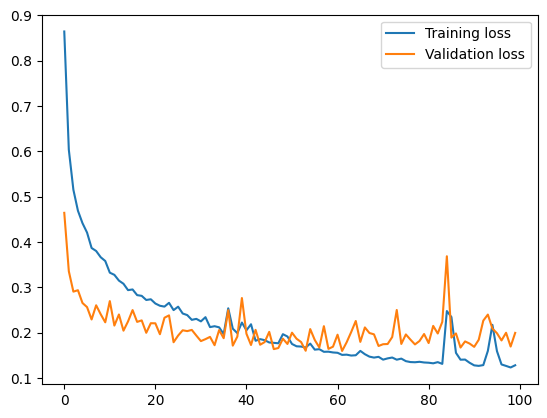

In [16]:
import matplotlib.pyplot as plt

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit([trainX], trainY, validation_split=0.1, epochs=100)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

Train

In [17]:
train_prediction = model.predict([trainX])
train_original = trainY

train_original.shape

66/66 [==============================] - 1s 5ms/step


(2085, 7)

In [18]:
train_original = train_original.flatten()
train_prediction = train_prediction.flatten()

In [21]:
train_prediction.shape

(14595,)

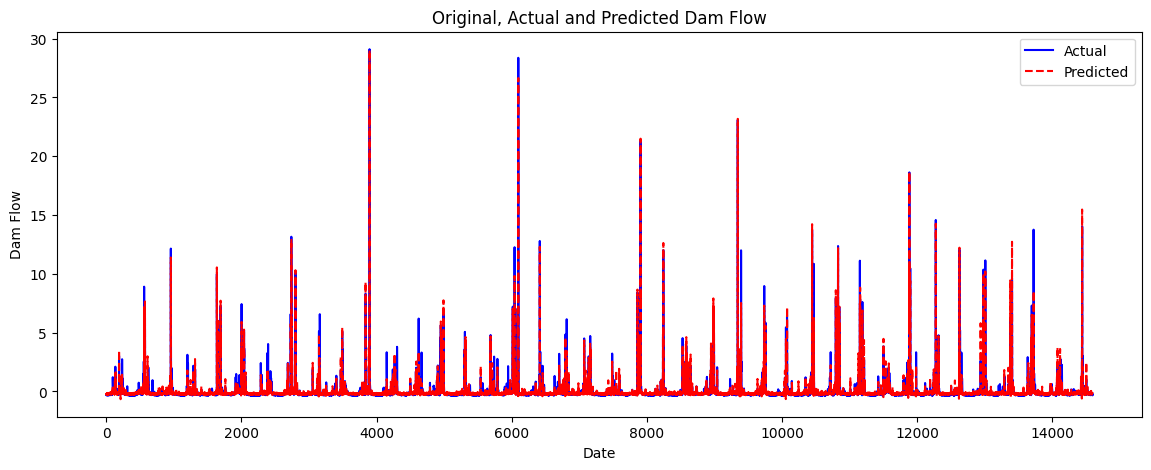

In [22]:
plt.figure(figsize=(14, 5))

# plot actual vs predicted
plt.plot(train_original, color='blue', label='Actual')
plt.plot(train_prediction, color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

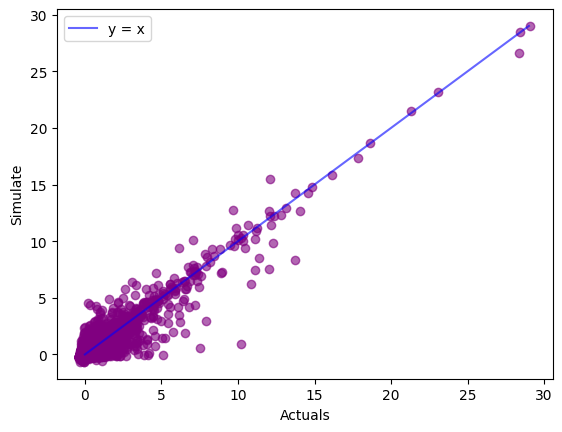

In [23]:
# 일대일 그래프
x = np.arange(0,max(max(train_original), max(train_prediction)))
y = x
plt.scatter(train_original[:], train_prediction[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [24]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(train_original, train_prediction))
print('RMSE : %.2f' %(rmse))

# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(train_original[:])
for i in range(len(train_original)):
  num1 = train_original[i] - train_prediction[i]
  num_sum1 += num1**2
  num2 = train_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

# PBIAS
num_sum1 = 0
for i in range(len(train_original)):
  num1 = train_original[i] - train_prediction[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(train_original[:])) * 100
print('PBIAS : %f' %pbias)

#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(train_original[:])
pred_avg = mean(train_prediction[:])
for i in range(len(train_original)):
  num1 = (train_original[i] - act_avg) * (train_prediction[i] - pred_avg)
  num_sum1 += num1
  num2 = train_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = train_prediction[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

RMSE : 0.36
NSE : 0.881742
PBIAS : -120.579053
R Square : 0.882425


Test

In [25]:
prediction = model.predict([testX])
original = testY

Scaleddam = damScaled.flatten()
flattenPrediction = prediction.flatten()
flattenOriginal = original.flatten()

inv_prediction = scaler.inverse_transform(prediction.reshape(-1,7))
inv_original = scaler.inverse_transform(original.reshape(-1,7))

17/17 [==============================] - 0s 4ms/step


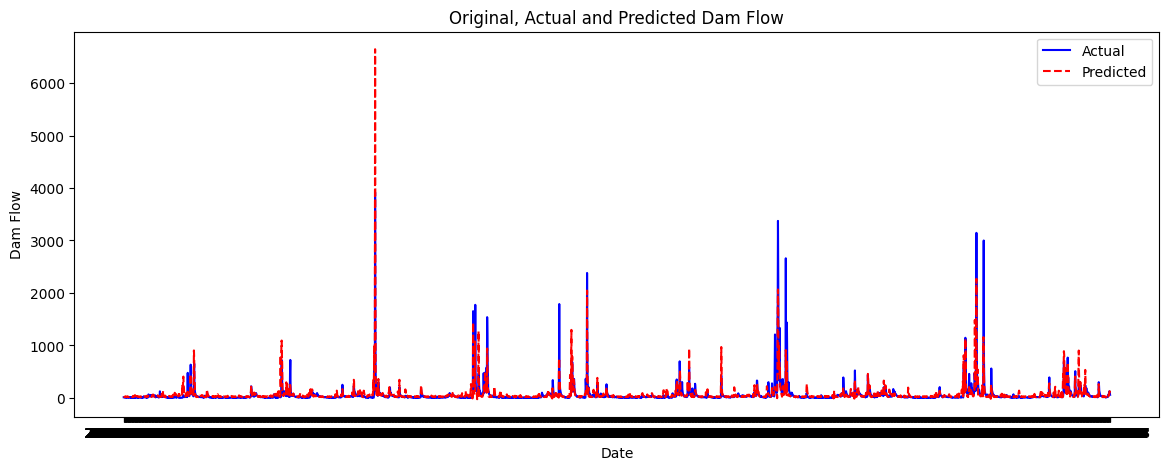

In [26]:
flatten_inv_prediction = inv_prediction.flatten()
flatten_inv_original = inv_original.flatten()

plt.figure(figsize=(14, 5))

# plot actual vs predicted
plt.plot(test_dates[split_index*7:], flatten_inv_original, color='blue', label='Actual')
plt.plot(test_dates[split_index*7:], flatten_inv_prediction, color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

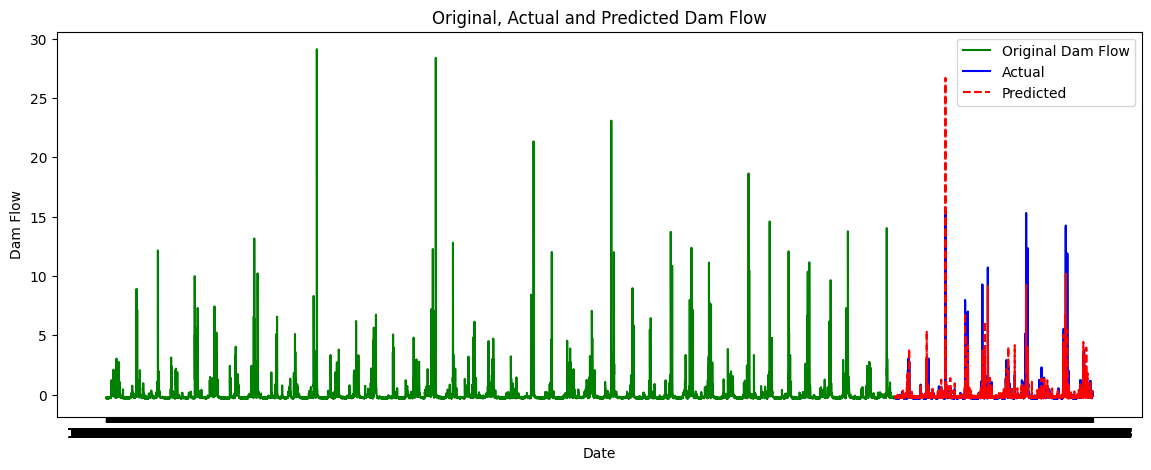

In [27]:
plt.figure(figsize=(14, 5))

# plot original
plt.plot(test_dates, Scaleddam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[split_index*7:], flattenOriginal, color='blue', label='Actual')
plt.plot(test_dates[split_index*7:], flattenPrediction, color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

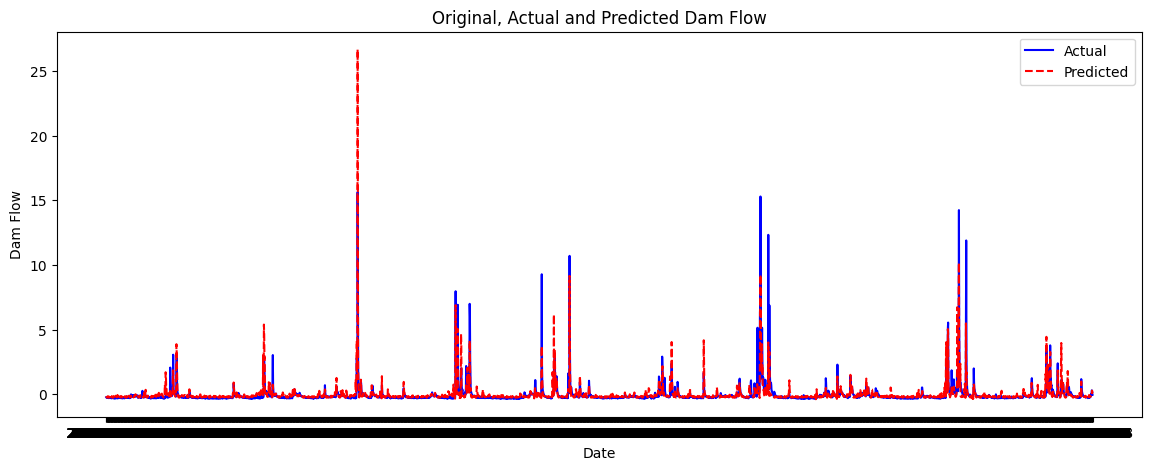

In [28]:
plt.figure(figsize=(14, 5))

# plot actual vs predicted
plt.plot(test_dates[split_index*7:], flattenOriginal, color='blue', label='Actual')
plt.plot(test_dates[split_index*7:], flattenPrediction, color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

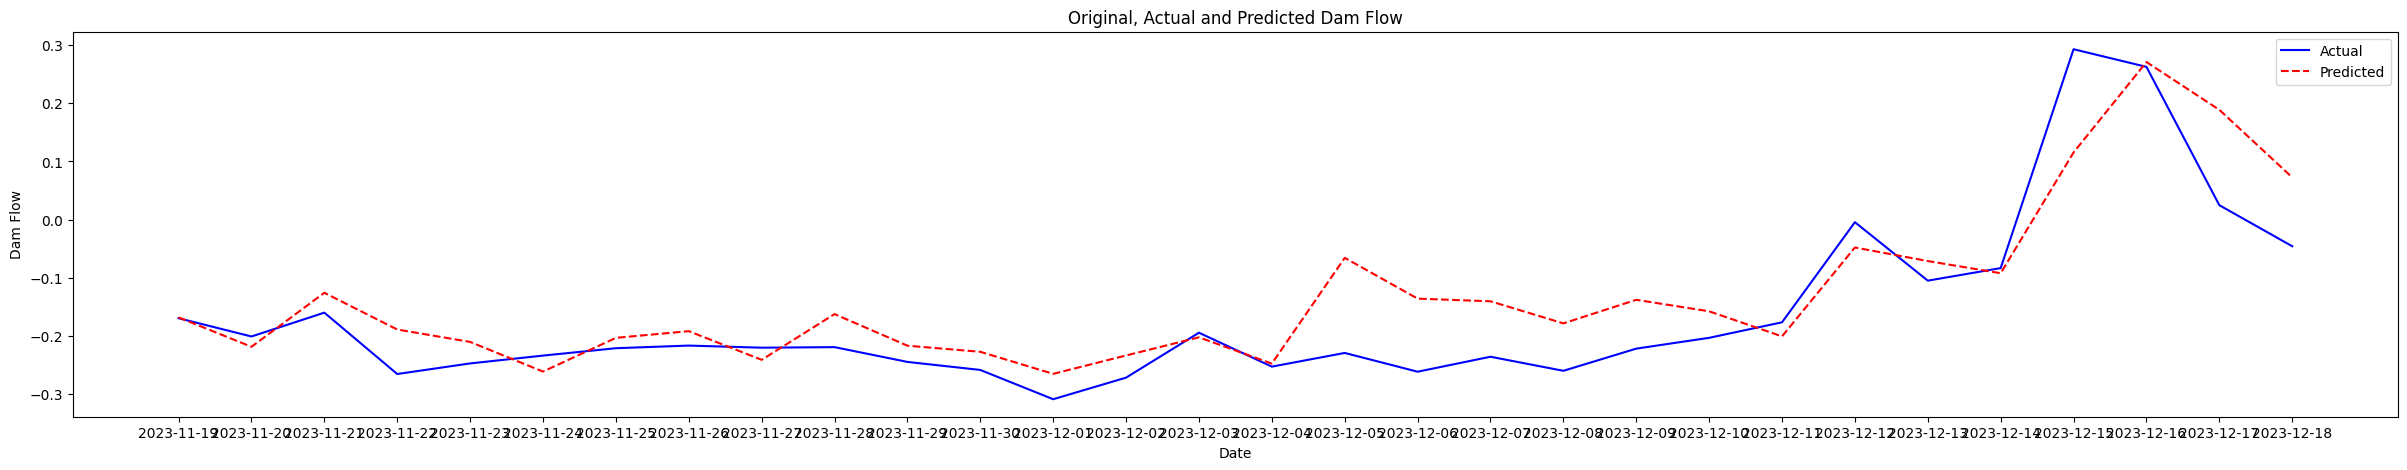

In [29]:
plt.figure(figsize=(30, 5))

# plot actual vs predicted
plt.plot(test_dates[-30:], flattenOriginal[-30:], color='blue', label='Actual')
plt.plot(test_dates[-30:], flattenPrediction[-30:], color='red', linestyle='--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

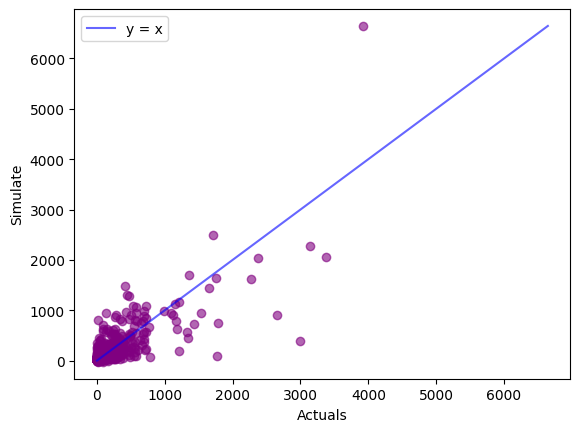

In [30]:
# 일대일 그래프
x = np.arange(0,max(max(flatten_inv_original), max(flatten_inv_prediction)))
y = x
plt.scatter(flatten_inv_original[:], flatten_inv_prediction[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [31]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(flattenOriginal, flattenPrediction))
print('RMSE : %.2f' %(rmse))

RMSE : 0.51


In [32]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(flattenOriginal[:])
for i in range(len(flattenOriginal)):
  num1 = flattenOriginal[i] - flattenPrediction[i]
  num_sum1 += num1**2
  num2 = flattenOriginal[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.617685


In [33]:
# PBIAS
num_sum1 = 0
for i in range(len(flattenOriginal)):
  num1 = flattenOriginal[i] - flattenPrediction[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(flattenOriginal[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : 80.361028


In [34]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(flattenOriginal[:])
pred_avg = mean(flattenPrediction[:])
for i in range(len(flattenOriginal)):
  num1 = (flattenOriginal[i] - act_avg) * (flattenPrediction[i] - pred_avg)
  num_sum1 += num1
  num2 = flattenOriginal[i] - pred_avg
  num_sum2 += num2**2
  num3 = flattenPrediction[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.645042
